In [1]:
import numpy as np
from PIL import Image
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertConfig, BertModel
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [13]:
images = []
descriptions = []
emotions = []
emotion_dic = {"positive":2, "negative":1, "neutral":0}
e_dataframe = pd.read_csv("./data/train.txt")
pre_trained = 'bert-base-uncased'
token = BertTokenizer.from_pretrained(pre_trained)

for i in range(e_dataframe.shape[0]):
    try:
        idx = e_dataframe.iloc[i]['guid']
        emotion = e_dataframe.iloc[i]['tag']
        img = Image.open('./data/data/' + str(idx) + '.jpg')
        img = img.resize((224,224),Image.ANTIALIAS)
        image = np.asarray(img, dtype = 'float32')
        with open('./data/data/' + str(idx) + '.txt', encoding='gbk') as fp:
            description = fp.read()
        images.append(image.transpose(2,0,1))
        descriptions.append(description)
        emotions.append(emotion_dic[emotion])
    except:
        continue

### 尝试对文本做预处理

In [14]:
descriptions[:5]

['RT @AmitSwami77: The conspirators have an evil eye & are now set to physically attack Asaram Bapu Ji! #WeDemandSafety4Bapuji http://t.co/N8…\n',
 'Waxwing trills, Chickadees calling "here sweetie", enthusiastic athletes, blue sky & snow at #ualbertafarm #UAlberta \n',
 '@NYSE is looking a little despondent today...??? http://t.co/o5xiKyJgT7\n',
 'FERVENT | S,M,L | 140k free PLASTIC CLIP, keychain rubber AND sticker 085725737197 / 28ae36f3 \n',
 'Nice day chilling in the park yesterday relieved my mood for a short while. #friends #summer #outside #depression \n']

In [15]:
for i in range(len(descriptions)):
    description = descriptions[i]
    words = description.replace("#", "").split(" ")
    words_filtered = []
    for word in words:
        if len(word)<1:
            continue
        elif word[:4]=='http' or word[0]=='@' or word=='RT':
            continue
        else:
            words_filtered.append(word)
    descriptions[i] = " ".join(words_filtered)

In [25]:
descriptions[:10]

['The conspirators have an evil eye & are now set to physically attack Asaram Bapu Ji! WeDemandSafety4Bapuji',
 'Waxwing trills, Chickadees calling "here sweetie", enthusiastic athletes, blue sky & snow at ualbertafarm UAlberta \n',
 'is looking a little despondent today...???',
 'FERVENT | S,M,L | 140k free PLASTIC CLIP, keychain rubber AND sticker 085725737197 / 28ae36f3 \n',
 'Nice day chilling in the park yesterday relieved my mood for a short while. friends summer outside depression \n',
 'Ford : F-350 Lariat 6.4L 2008 Lariat Heated Leather Rear Camera 2008 ford f 250 diesel 4 x… \n',
 'Furious 7',
 'The flowers look like a dejected King Tritan: \n',
 '廃墟 廃線 abandoned 写真撮ってる人と繋がりたい 写真好きな人と繋がりたい \n',
 "UPDATE!Navy discarded ilegal fishing after boarding chinese vessels in Chile's Excl Econ Zone htt… \n"]

In [17]:
def text2emb(texts):
    data = token.batch_encode_plus(batch_text_or_text_pairs = texts, 
                                   truncation=True, padding='max_length', max_length=32,
                                   return_tensors='pt')
    input_ids = data['input_ids']
    attention_mask = data["attention_mask"]
    return input_ids, attention_mask

In [18]:
count = Counter(emotions)
print(count)

Counter({2: 2387, 1: 1193, 0: 419})


In [19]:
image_and_txt = [(images[i], descriptions[i]) for i in range(len(images))]
x_train, x_test, emotion_train, emotion_test = train_test_split(image_and_txt, emotions, test_size=0.2, random_state=0)
image_train, txt_train = [x_train[i][0] for i in range(len(x_train))], [x_train[i][1] for i in range(len(x_train))]
image_test, txt_test = [x_test[i][0] for i in range(len(x_test))], [x_test[i][1] for i in range(len(x_test))]

In [20]:
class Lab5Dataset():
    def __init__(self, images, descriptions, emotions):
        self.images = images
        self.input_ids, self.attention_masks = text2emb(descriptions)
        self.emotions = emotions

    def __getitem__(self, index):
        image = self.images[index]
        input_id = self.input_ids[index]
        attention_mask = self.attention_masks[index]
        emotion = self.emotions[index]
        return image, input_id, attention_mask, emotion

    def __len__(self):
        return len(self.images)

In [21]:
train_dataset = Lab5Dataset(image_train, txt_train, emotion_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 16, shuffle = True)
test_dataset = Lab5Dataset(image_test, txt_test, emotion_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 16, shuffle = True)

In [22]:
class Bert(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.linear1 = nn.Linear(768, 256)
        self.linear2 = nn.Linear(256, 3)

    def forward(self, input_ids, input_mask):
        out = self.bert(input_ids = input_ids, attention_mask = input_mask) 
        out = out.last_hidden_state[:,0,:]
        out.view(out.shape[0], -1)
        out = self.linear1(out)
        out = self.linear2(out)
        return out

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Bert().to(device)
optimizer = optim.AdamW(model.parameters(), lr = 1e-6)
Loss = nn.CrossEntropyLoss()
train_acc = []
test_acc = []
for epoch in range(15):
    for batch_idx, (_, idx, mask, target) in enumerate(train_dataloader):
        idx, mask, target = idx.to(device), mask.to(device), target.to(device)
        output = model(idx, mask)
        optimizer.zero_grad()
        loss = Loss(output, target)
        loss.backward()
        optimizer.step()
        if (batch_idx + 1) % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx+1, len(train_dataloader), 100. * (batch_idx+1) / len(train_dataloader), loss.item()))

    correct = 0
    for _, idx, mask, target in train_dataloader:
        idx, mask, target = idx.to(device), mask.to(device), target.to(device)
        output = model(idx, mask)
        pred = output.argmax(dim=1)
        correct += int(pred.eq(target).sum())
    train_acc.append(correct / len(image_train))
    print('Train Accuracy: {:.6f}'.format(correct / len(image_train)))

    correct = 0
    for _, idx, mask, target in test_dataloader:
        idx, mask, target = idx.to(device), mask.to(device), target.to(device)
        output = model(idx, mask)
        pred = output.argmax(dim=1)
        correct += int(pred.eq(target).sum())
    test_acc.append(correct / len(image_test))
    print('Test Accuracy: {:.6f}'.format(correct / len(image_test)))
    
torch.save(model.state_dict(), "./bert.kpl")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train Epoch: 0 [50/200 (25%)]	Loss: 1.000721
Train Epoch: 0 [100/200 (50%)]	Loss: 1.082980
Train Epoch: 0 [150/200 (75%)]	Loss: 0.910942
Train Epoch: 0 [200/200 (100%)]	Loss: 0.791775
Train Accuracy: 0.594873
Test Accuracy: 0.632500
Train Epoch: 1 [50/200 (25%)]	Loss: 0.774241
Train Epoch: 1 [100/200 (50%)]	Loss: 0.955986
Train Epoch: 1 [150/200 (75%)]	Loss: 0.921791
Train Epoch: 1 [200/200 (100%)]	Loss: 0.933420
Train Accuracy: 0.641450
Test Accuracy: 0.663750
Train Epoch: 2 [50/200 (25%)]	Loss: 0.901869
Train Epoch: 2 [100/200 (50%)]	Loss: 0.574206
Train Epoch: 2 [150/200 (75%)]	Loss: 0.802193
Train Epoch: 2 [200/200 (100%)]	Loss: 0.582512
Train Accuracy: 0.703032
Test Accuracy: 0.706250
Train Epoch: 3 [50/200 (25%)]	Loss: 0.773984
Train Epoch: 3 [100/200 (50%)]	Loss: 0.788280
Train Epoch: 3 [150/200 (75%)]	Loss: 0.694514
Train Epoch: 3 [200/200 (100%)]	Loss: 0.812681
Train Accuracy: 0.743045
Test Accuracy: 0.712500
Train Epoch: 4 [50/200 (25%)]	Loss: 0.517134
Train Epoch: 4 [100/200

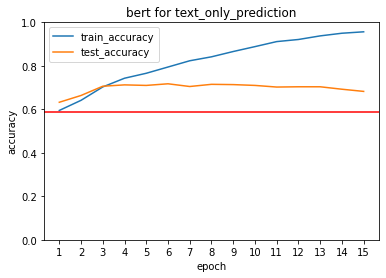

In [24]:
plt.plot(train_acc, label="train_accuracy")
plt.plot(test_acc, label="test_accuracy")
plt.axhline(Counter(emotion_train)[2]/len(emotion_train), color='red')
plt.title("bert for text_only_prediction")
plt.xlabel("epoch")
plt.xticks(range(15), range(1, 16))
plt.ylabel("accuracy")
plt.ylim(ymin=0, ymax=1)
plt.legend()
plt.savefig('./text_only_prediction_preprocessed.jpg')
plt.show()

### 